In [2]:
import numpy as np
import healpy as hp
import pandas as pd
from scipy import integrate
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo

In [3]:
SM_cat = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data

print('the file is open, and it has',len(SM_cat), 'number of objects')

the file is open, and it has 370116 number of objects


In [31]:
#z_max = 0.08
z_max = 0.1 # ~430 Mpc
masks = (
         (SM_cat['uberclass'] == 1 ) & #galaxy
         (SM_cat['duplicate'] == False) &
         (SM_cat['mask'] == False) &
         (SM_cat['starmask'] == False) &
         (SM_cat['NQ'] > 2) &
         (SM_cat['SC'] > 7) &
         (SM_cat['Z'] < z_max) &
         (SM_cat['flux_rt'] > 10**(-4.3))
)

SM_cat = SM_cat[masks]
print('SM_cat, number of objects with masks:',len(SM_cat))

SM_cat, number of objects with masks: 13878


/tmp/ipykernel_19980/2743228272.py:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(SM_cat['mstar']), SM_cat['Z'], 'k,', rasterized = True)


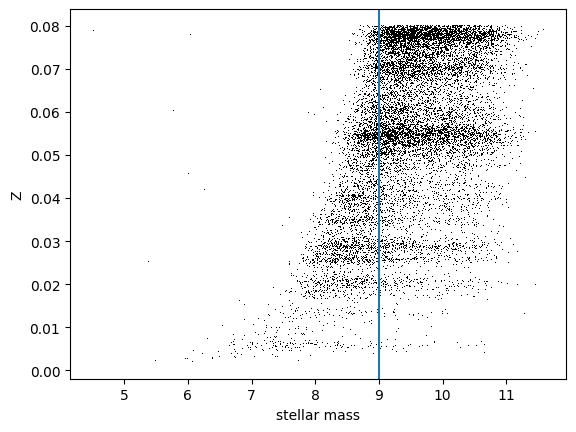

In [22]:
plt.plot(np.log10(SM_cat['mstar']), SM_cat['Z'], 'k,', rasterized = True)
plt.xlabel('stellar mass')
plt.ylabel('Z')
plt.axvline(9)

In [23]:
regions_of_sky = {
    # 'G02': {'RAcen': (30.20, 38.80), 'DECcen': (-10.25, -3.72)},
    'G09': {'RAcen': (129.0, 141.0), 'DECcen': (-2.0, 3.0)},
    'G12': {'RAcen': (174.0, 186.0), 'DECcen': (-3.0, 2.0)},
    'G15': {'RAcen': (211.5, 223.5), 'DECcen': (-2.0, 3.0)},
    'G23': {'RAcen': (339.0, 351.0), 'DECcen': (-35.0, -30.0)},
}

MS_regions = ['G09', 'G12', 'G15', 'G23']
MS = {region_name: regions_of_sky[region_name] for region_name in MS_regions}

MS_SM_cat = {region_name: SM_cat[(
    (SM_cat['RAcen'] >= region_params['RAcen'][0]) & (SM_cat['RAcen'] <= region_params['RAcen'][1]) &
    (SM_cat['DECcen'] >= region_params['DECcen'][0]) & (SM_cat['DECcen'] <= region_params['DECcen'][1])
) ] for region_name, region_params in MS.items()}

In [24]:
# Functions

# Function to calculate the area for a given patch
def calculate_patch_area(patch, nside):
    RA_min, RA_max = np.deg2rad(patch['RAcen'])
    DEC_min, DEC_max = np.deg2rad(patch['DECcen'])

    # Calculate the pixel indices for the given patch
    pix_indices = np.arange(hp.nside2npix(nside))
    pix_indices_patch = pix_indices[
        (hp.pixelfunc.pix2ang(nside, pix_indices)[0] >= np.pi/2 - DEC_max) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[0] <= np.pi/2 - DEC_min) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[1] >= RA_min) &
        (hp.pixelfunc.pix2ang(nside, pix_indices)[1] <= RA_max)
    ]

    # Calculate the area of the given patch using the average solid angle of a pixel
    average_pixel_area = 4 * np.pi / (12 * nside**2)
    patch_area = len(pix_indices_patch) * average_pixel_area

    return patch_area


# Function to calculate volume (Mpc^3)
def calculate_volume(radius, fraction):
    return 4 / 3 * np.pi * radius ** 3 * fraction

# Function to calculate error
def calculate_error(y_data, N):
    return np.sqrt((y_data * N**(-1/2))**2 + (y_data * 0.043)**2)

# def get_completeness_from_mag(magnitude):

In [8]:
# Healpy

nside = 4096    # highest resolution
average_pixel_area = 4 * np.pi / (12 * nside**2)
total_area_sphere = hp.nside2npix(nside) * average_pixel_area
np.set_printoptions(precision=5)

# Area and fraction of patches
for region_name, region in regions_of_sky.items():
    region_area = calculate_patch_area(region, nside)
    fraction = region_area / total_area_sphere

# Calculate the total area of the patches
total_area_regions = sum(calculate_patch_area(region, nside) for region in regions_of_sky.values())

Area of patch G09: 0.018283682792586815 rad^2
Fraction of patch G09: 0.0014549692471822102
Area of patch G12: 0.018283682792586815 rad^2
Fraction of patch G12: 0.0014549692471822102
Area of patch G15: 0.01826695481198975 rad^2
Fraction of patch G15: 0.0014536380767822263
Area of patch G23: 0.01543830322729731 rad^2
Fraction of patch G23: 0.0012285411357879639


In [33]:
mass_bins = 10**np.arange(5,12.25,0.25)
print(mass_bins)

0.00559211770693461 0.006020759579028491
[1.00000e+05 1.77828e+05 3.16228e+05 5.62341e+05 1.00000e+06 1.77828e+06
 3.16228e+06 5.62341e+06 1.00000e+07 1.77828e+07 3.16228e+07 5.62341e+07
 1.00000e+08 1.77828e+08 3.16228e+08 5.62341e+08 1.00000e+09 1.77828e+09
 3.16228e+09 5.62341e+09 1.00000e+10 1.77828e+10 3.16228e+10 5.62341e+10
 1.00000e+11 1.77828e+11 3.16228e+11 5.62341e+11 1.00000e+12]


In [26]:
# Dictionary of mass histogram

dict_mass_hist = {}
dict_simple_mass_hist = {}
for region_name in regions_of_sky.keys():
    Mass_obj = MS_SM_cat[region_name]['mstar']                  # in units of M_{sun}
    m_histogram = np.histogram(Mass_obj,mass_bins)[0]           # number of objects is in each bin
    dict_mass_hist[region_name] = m_histogram
    m_histogram_weighted = m_histogram / 0.95                   # N(w) = numbers of the object is in each bin / (avarage complteness)
    dict_simple_mass_hist[region_name] = m_histogram_weighted
    print(m_histogram)

[  0   1   0   1   1   1   1   3   2   5  13  42  64 138 207 346 473 461
 329 348 288 246 173  90  30   6   0   0]
[  0   0   0   2   3   5   5   3  15  19  23  68 103 147 234 355 539 526
 480 428 324 303 236 116  35   4   0   0]
[  0   1   0   0   1   0   3   2   3  13  19  35 106 189 325 469 551 444
 431 318 331 278 175  83  29   5   1   0]
[  0   0   0   0   0   0   4   5   2   7   8  17  38  95 151 300 407 391
 348 295 258 221 152  84  27   7   1   0]


In [27]:
# Dictionary of volumes

dict_regions_volumes = {}
for region_name, region in regions_of_sky.items():
    region_volume = calculate_volume(cosmo.comoving_distance(z_max), fraction)
    dict_regions_volumes[region_name] = region_volume

print('volume of each region (Mpc^3)')
print(dict_regions_volumes, 'steradian')

volume of each region (Mpc^3)
{'G09': <Quantity 415245.51177 Mpc3>, 'G12': <Quantity 415245.51177 Mpc3>, 'G15': <Quantity 415245.51177 Mpc3>, 'G23': <Quantity 415245.51177 Mpc3>} steradian


In [28]:
# N(w)/V: weighted number density over volume

dict_mass_func = {}
for region_name in regions_of_sky.keys():
    dict_mass_func[region_name] = dict_simple_mass_hist[region_name] / dict_regions_volumes[region_name]
print(dict_mass_func)

{'G09': <Quantity [0.00000e+00, 2.53496e-06, 0.00000e+00, 2.53496e-06, 2.53496e-06,
           2.53496e-06, 2.53496e-06, 7.60489e-06, 5.06992e-06, 1.26748e-05,
           3.29545e-05, 1.06468e-04, 1.62238e-04, 3.49825e-04, 5.24737e-04,
           8.77097e-04, 1.19904e-03, 1.16862e-03, 8.34002e-04, 8.82167e-04,
           7.30069e-04, 6.23601e-04, 4.38548e-04, 2.28147e-04, 7.60489e-05,
           1.52098e-05, 0.00000e+00, 0.00000e+00] 1 / Mpc3>, 'G12': <Quantity [0.00000e+00, 0.00000e+00, 0.00000e+00, 5.06992e-06, 7.60489e-06,
           1.26748e-05, 1.26748e-05, 7.60489e-06, 3.80244e-05, 4.81643e-05,
           5.83041e-05, 1.72377e-04, 2.61101e-04, 3.72639e-04, 5.93181e-04,
           8.99911e-04, 1.36634e-03, 1.33339e-03, 1.21678e-03, 1.08496e-03,
           8.21328e-04, 7.68093e-04, 5.98251e-04, 2.94056e-04, 8.87237e-05,
           1.01398e-05, 0.00000e+00, 0.00000e+00] 1 / Mpc3>, 'G15': <Quantity [0.00000e+00, 2.53496e-06, 0.00000e+00, 0.00000e+00, 2.53496e-06,
           0.00000e+

/tmp/ipykernel_19980/1504312766.py:30: RuntimeWarning: divide by zero encountered in power
  return np.sqrt((y_data * N**(-1/2))**2 + (y_data * 0.043)**2)
/home/farnoosh/.local/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


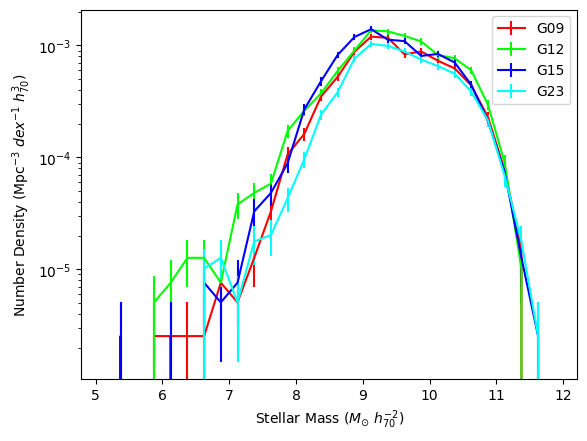

In [29]:
# Plot
region_colors = {'G09': 'red', 'G12': 'lime', 'G15': 'blue', 'G23': 'cyan'}

for region_name in regions_of_sky.keys():
    errors = calculate_error(dict_mass_func[region_name], dict_mass_hist[region_name])
    plt.errorbar(np.log10(mass_bins[:-1])+(0.25/2), dict_mass_func[region_name], yerr=errors,
             label=region_name, color=region_colors[region_name])

plt.xlabel('Stellar Mass ($M_{\odot} \ h_{70}^{-2}$)')
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ h_{70}^{3}$)')
plt.yscale('log')
plt.legend()
plt.show()
